In [183]:
from wristpy.ggir import compare_dataframes
file_name = '/Users/freymon.perez/Documents/raw_gt3x_data_archive/NDARFE868RRJ.gt3x'


In [184]:
import wristpy

In [185]:
from wristpy.common import data_model

In [186]:
from wristpy.io.loaders import gt3x

In [187]:
test_config = wristpy.common.data_model.Config(file_name, file_name)
test_config.path_input

'/Users/freymon.perez/Documents/raw_gt3x_data_archive/NDARFE868RRJ.gt3x'

In [188]:
test_data = gt3x.load(test_config.path_input)

In [189]:
test_data.time

array(['2020-12-29T16:03:00.000', '2020-12-29T16:03:00.016',
       '2020-12-29T16:03:00.033', ..., '2021-01-22T09:02:58.950',
       '2021-01-22T09:02:58.966', '2021-01-22T09:02:58.983'],
      dtype='datetime64[ms]')

In [190]:
test_data.acceleration

X,Y,Z
f32,f32,f32
0.546875,-0.546875,0.3671875
0.4921875,-0.644531,0.457031
0.3984375,-0.511719,0.140625
0.3046875,-0.300781,0.105469
0.265625,-0.097656,0.03125
…,…,…
0.015625,0.003906,-0.984375
0.015625,0.003906,-0.988281
0.015625,0.003906,-0.988281


In [191]:
from wristpy.ggir import metrics_calc
from wristpy.ggir import calibration

In [192]:
import importlib


In [193]:
importlib.reload(calibration)
importlib.reload(data_model)

<module 'wristpy.common.data_model' from '/Users/freymon.perez/Projects/wristpy/src/wristpy/common/data_model.py'>

In [194]:
test_output = calibration.start_ggir_calibration(test_data)

/Users/freymon.perez/Projects/wristpy/src/wristpy/ggir/calibration.py:214: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[[ 0.00958898]
 [ 0.00955671]
 [ 0.00980192]
 ...
 [ 0.60424112]
 [ 0.61233946]
 [-0.61131345]]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  curr.iloc[:, k] = x_ @ LR.coef_
/Users/freymon.perez/Projects/wristpy/src/wristpy/ggir/calibration.py:214: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[[ 0.0090509 ]
 [ 0.00901859]
 [ 0.00926413]
 ...
 [ 0.60449875]
 [ 0.61260792]
 [-0.61268236]]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  curr.iloc[:, k] = x_ @ LR.coef_
/Users/freymon.perez/Projects/wristpy/src/wristpy/ggir/calibration.py:214: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error

In [195]:
test_output.sampling_rate

60

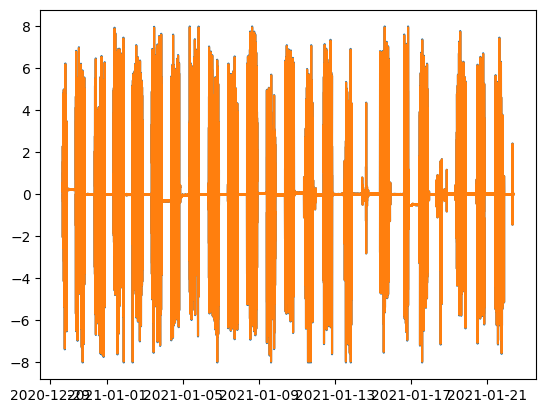

In [196]:
from matplotlib import pyplot as plt 

plt.plot(test_data.time, test_data.acceleration['X'])
plt.plot(test_output.time, test_output.cal_acceleration['X'])
plt.show()

In [197]:
importlib.reload(metrics_calc)
importlib.reload(data_model)


<module 'wristpy.common.data_model' from '/Users/freymon.perez/Projects/wristpy/src/wristpy/common/data_model.py'>

In [198]:
metrics_calc.calc_base_metrics(test_output)

In [199]:
test_output.enmo

enmo
f32
0.0
0.0
0.0
0.0
0.0
…
0.0
0.0
0.0


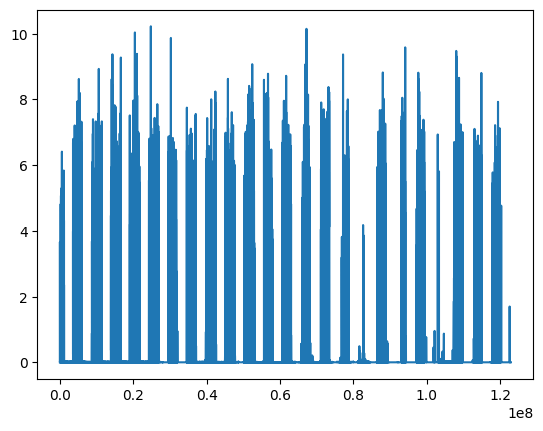

In [200]:
plt.plot(test_output.enmo)
plt.show()

In [201]:
metrics_calc.calc_epoch1_metrics(test_output)


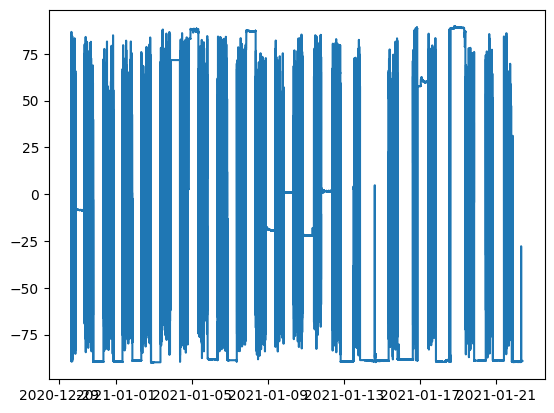

In [202]:
plt.plot(test_output.time_epoch1, test_output.anglez_epoch1)
plt.show()

In [203]:
ggir_data = compare_dataframes.load_ggir_output("/Users/freymon.perez/Documents/ggir_raw_outputs_group1/NDARFE868RRJ.gt3x.RData.csv")

In [204]:
difference_df, outputdata_trimmed = compare_dataframes.compare(
                                    ggir_dataframe= ggir_data,
                                    wristpy_dataframe=test_output
)

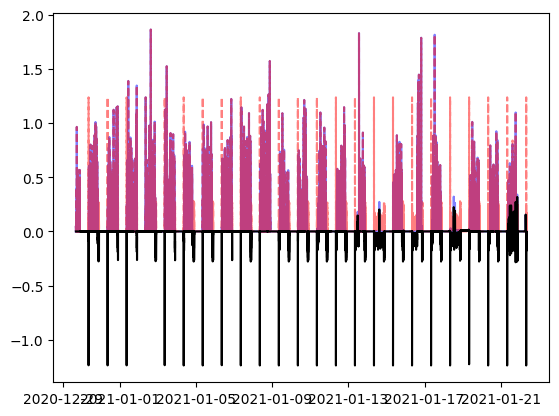

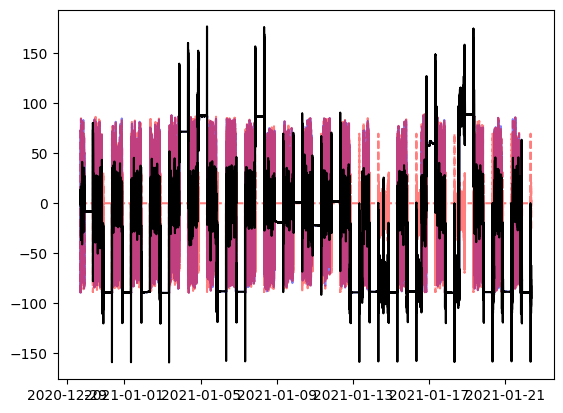

In [205]:
compare_dataframes.plot_diff(
    difference_df= difference_df,
    outputdata_trimmed= outputdata_trimmed,
    ggir_dataframe= ggir_data,
    opacity= 0.5
)

In [182]:
importlib.reload(compare_dataframes)

<module 'wristpy.ggir.compare_dataframes' from '/Users/freymon.perez/Projects/wristpy/src/wristpy/ggir/compare_dataframes.py'>